In [1]:
# import libraries
import pandas as pd
import numpy as np
from scipy.stats import zscore
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from sklearn.preprocessing import LabelEncoder
import warnings
from sklearn.exceptions import ConvergenceWarning
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier

In [2]:
df=pd.read_excel('raw_sales_data.xlsx') #load dataset
df

,Customer_ID,Customer_Name,Region,Total_Spend,Purchase_Frequency,Marketing_Spend,Seasonality_Index,Churned
0,101,John Doe,North,5000,12,2000,1.2,No
1,102,Jane Smith,South,3000,8,1500,1.0,Yes
2,103,Sam Brown,East,4500,10,1800,1.1,No
3,104,Linda Johnson,West,2500,5,1000,0.9,Yes
4,105,Michael Lee,North,7000,15,2500,1.3,No
5,106,Emily Davis,South,3200,7,1400,1.0,Yes
6,107,David Wilson,East,5300,14,2300,1.2,No
7,108,Susan White,West,2900,6,1100,0.8,Yes
8,109,Chris Martin,North,6000,13,2200,1.2,No
9,110,Anna Taylor,South,3100,8,1350,0.9,Yes


In [3]:
print("Shape of the dataset",df.shape)

Shape of the dataset (16, 8)


In [4]:
null_counts=df.isnull().sum() #count null values in columns
print("Number of null values per column")
print(null_counts)

Number of null values per column
Customer_ID           0
Customer_Name         0
Region                0
Total_Spend           0
Purchase_Frequency    0
Marketing_Spend       0
Seasonality_Index     0
Churned               0
dtype: int64


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16 entries, 0 to 15
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Customer_ID         16 non-null     int64  
 1   Customer_Name       16 non-null     object 
 2   Region              16 non-null     object 
 3   Total_Spend         16 non-null     int64  
 4   Purchase_Frequency  16 non-null     int64  
 5   Marketing_Spend     16 non-null     int64  
 6   Seasonality_Index   16 non-null     float64
 7   Churned             16 non-null     object 
dtypes: float64(1), int64(4), object(3)
memory usage: 1.1+ KB


In [6]:
# to find number of duplicates in data set
no_of_duplicates=df.duplicated().sum()
no_of_duplicates

0

In [7]:
df.loc[2, 'Total_Spend'] = None
df.loc[5, 'Seasonality_Index'] = None
df.loc[7, 'Region'] = None

In [8]:
#impute with mean
df['Total_Spend'] = df['Total_Spend'].fillna(df['Total_Spend'].mean())

In [9]:
#impute with median
df['Seasonality_Index'] = df['Seasonality_Index'].fillna(df['Seasonality_Index'].median())

In [10]:
# Impute with mode (for categorical columns)
df['Region'] = df['Region'].fillna(df['Region'].mode()[0])

In [11]:
print("Missing values after imputation:")
print(df.isnull().sum())

Missing values after imputation:
Customer_ID           0
Customer_Name         0
Region                0
Total_Spend           0
Purchase_Frequency    0
Marketing_Spend       0
Seasonality_Index     0
Churned               0
dtype: int64


In [12]:
from scipy import stats
numeric_cols = df.select_dtypes(include=[np.number]).columns
# Compute Z-scores
z_scores = np.abs(stats.zscore(df[numeric_cols]))

threshold=3

# Filter: keep only rows where all z-scores < threshold
df_zscore_cleaned = df[(z_scores < threshold).all(axis=1)]

print("Shape after Z-score outlier removal:", df_zscore_cleaned.shape)

Shape after Z-score outlier removal: (16, 8)


# 2. Predictive Modeling for Sales Forecasting

In [13]:
# LinearRegression

x=df[['Marketing_Spend','Seasonality_Index']]
y=df['Total_Spend']

# split into train/test sets
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.5, random_state=47)

#create and train model
model=LinearRegression()
model.fit(x_train,y_train)

#predict
y_pred=model.predict(x_test)

#Evulate
mse=mean_squared_error(y_test,y_pred)
r2=r2_score(y_test,y_pred)

print("Mean Squared Error :",mse)
print("R-Squares :", r2)
print("Coefficients :",model.coef_)
print("Intercept :",model.intercept_)

Mean Squared Error : 164480.30943515964
R-Squares : 0.9103394375077112
Coefficients : [ 2.57495591 17.6366843 ]
Intercept : -149.38271604938382


In [14]:
# Logistic Regression

# Encode the target column ('Churned': Yes/No) into binary
le = LabelEncoder()
df['Churned_Encoded'] = le.fit_transform(df['Churned'])  # Yes=1, No=0

# Define features and target
X = df[['Total_Spend', 'Marketing_Spend', 'Seasonality_Index', 'Purchase_Frequency']]
y = df['Churned_Encoded']

# Split into training/testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=47)


# Logistic Regression with higher max_iter and alternative solver
model = LogisticRegression(max_iter=1000, solver='liblinear')
model.fit(X_train, y_train)

# Predict on test set
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

# Output
print("Accuracy:", accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", report)

Accuracy: 0.875
Confusion Matrix:
 [[3 1]
 [0 4]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.80      1.00      0.89         4

    accuracy                           0.88         8
   macro avg       0.90      0.88      0.87         8
weighted avg       0.90      0.88      0.87         8



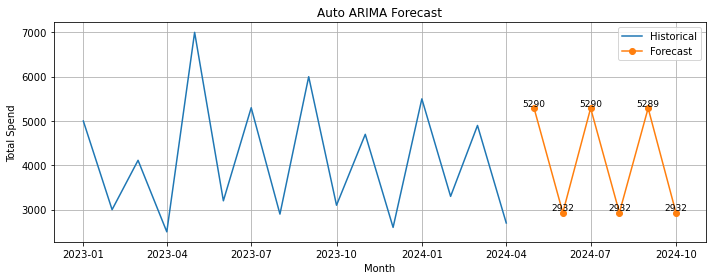

In [15]:
from pmdarima import auto_arima

# Create a time index (assume monthly)
df['Month'] = pd.date_range(start='2023-01-01', periods=len(df), freq='MS')
df.set_index('Month', inplace=True)

# Use Total_Spend as time series
ts = df['Total_Spend']

# Auto ARIMA model
model = auto_arima(ts, seasonal=False, stepwise=True)

# Forecast next 6 months
forecast = model.predict(n_periods=6)

# Create future dates for plotting
future_index = pd.date_range(start=ts.index[-1] + pd.DateOffset(months=1), periods=6, freq='MS')

# Plot
plt.figure(figsize=(10, 4))
plt.plot(ts, label='Historical')
plt.plot(future_index, forecast, label='Forecast', marker='o')

# Add value labels
for i, val in zip(future_index, forecast):
    plt.text(i, val, f"{val:.0f}", ha='center', va='bottom', fontsize=9)

plt.title("Auto ARIMA Forecast")
plt.xlabel("Month")
plt.ylabel("Total Spend")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 3. Statistical Analysis for Business Insights

In [16]:
from scipy.stats import f_oneway

In [17]:
# ANOVA

# Group Total_Spend by Region
regions = df['Region'].unique()
sales_by_region = [df[df['Region'] == region]['Total_Spend'] for region in regions]

# Perform one-way ANOVA
f_stat, p_value = f_oneway(*sales_by_region)

# Output results
print("ANOVA F-statistic:", f_stat)
print("P-value:", p_value)

# Interpret result
if p_value < 0.10:
    print("Statistically significant difference in sales across regions (reject H0)")
else:
    print("No statistically significant difference in sales across regions (fail to reject H0)")

ANOVA F-statistic: 16.283334346689355
P-value: 0.0001572261937237853
Statistically significant difference in sales across regions (reject H0)


In [18]:
# Hypothesis Testing

from scipy.stats import ttest_ind
# Create a simple Promotion column for demo (1 = promo, 0 = no promo)
df['Promotion'] = [1 if i % 2 == 0 else 0 for i in range(len(df))]

# Split data
promo = df[df['Promotion'] == 1]['Total_Spend']
no_promo = df[df['Promotion'] == 0]['Total_Spend']

# T-test
t_stat, p = ttest_ind(promo, no_promo)

# Print result
print("P-value:", p)
if p < 0.05:
    print("Promotion has significant impact on sales.")
else:
    print("No significant impact from promotion.")


P-value: 3.780492527237806e-06
Promotion has significant impact on sales.


In [19]:
# Factor Analysis

from sklearn.decomposition import FactorAnalysis
from sklearn.preprocessing import StandardScaler

# Select relevant numerical features
features = ['Total_Spend', 'Marketing_Spend', 'Purchase_Frequency', 'Seasonality_Index']
X = df[features]

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply Factor Analysis (let's extract 2 factors)
fa = FactorAnalysis(n_components=2, random_state=42)
factors = fa.fit_transform(X_scaled)

# Create a DataFrame with factor loadings
loadings = pd.DataFrame(fa.components_.T, index=features, columns=['Factor1', 'Factor2'])

print("Factor Loadings:\n")
print(loadings)

Factor Loadings:

                     Factor1   Factor2
Total_Spend         0.970189 -0.017096
Marketing_Spend     0.998396  0.005355
Purchase_Frequency  0.991845 -0.059107
Seasonality_Index   0.941683  0.223978


# 4. Machine Learning for Customer Segmentation

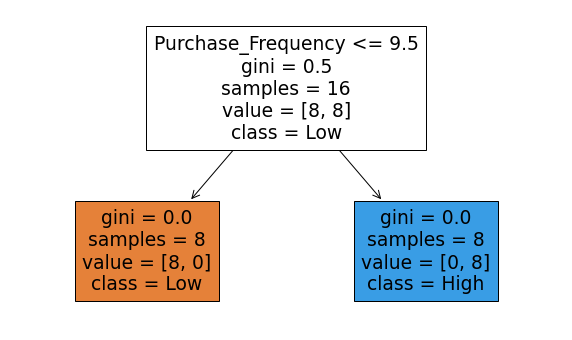

In [20]:
# Decision Tree

# Label customers: 1 = High spender, 0 = Low spender
df['Segment'] = (df['Total_Spend'] > df['Total_Spend'].median()).astype(int)

# Select features
X = df[['Marketing_Spend', 'Purchase_Frequency', 'Seasonality_Index']]
y = df['Segment']

# Train decision tree
model = DecisionTreeClassifier()
model.fit(X, y)

# Plot tree
plt.figure(figsize=(10, 6))
plot_tree(model, feature_names=X.columns, class_names=['Low', 'High'], filled=True)
plt.show()

In [21]:
# Implement K-Means Clustering to group customers into different spending categories

from sklearn.cluster import KMeans
# Use Total_Spend only for simple clustering
X = df[['Total_Spend']]

# Apply K-Means (3 groups)
kmeans = KMeans(n_clusters=3, random_state=0)
df['Cluster'] = kmeans.fit_predict(X)

# Show result
print(df[['Customer_Name', 'Total_Spend', 'Cluster']])

              Customer_Name  Total_Spend  Cluster
Month                                            
2023-01-01         John Doe  5000.000000        0
2023-02-01       Jane Smith  3000.000000        1
2023-03-01        Sam Brown  4113.333333        0
2023-04-01    Linda Johnson  2500.000000        1
2023-05-01      Michael Lee  7000.000000        2
2023-06-01      Emily Davis  3200.000000        1
2023-07-01     David Wilson  5300.000000        0
2023-08-01      Susan White  2900.000000        1
2023-09-01     Chris Martin  6000.000000        2
2023-10-01      Anna Taylor  3100.000000        1
2023-11-01   James Anderson  4700.000000        0
2023-12-01  Patricia Thomas  2600.000000        1
2024-01-01   Robert Jackson  5500.000000        0
2024-02-01      Mary Harris  3300.000000        1
2024-03-01     Daniel Clark  4900.000000        0
2024-04-01    Barbara Lewis  2700.000000        1


              Customer_Name  Total_Spend  Spending_Cluster
Month                                                     
2023-01-01         John Doe  5000.000000                 1
2023-02-01       Jane Smith  3000.000000                 0
2023-03-01        Sam Brown  4113.333333                 0
2023-04-01    Linda Johnson  2500.000000                 2
2023-05-01      Michael Lee  7000.000000                 1
2023-06-01      Emily Davis  3200.000000                 0
2023-07-01     David Wilson  5300.000000                 1
2023-08-01      Susan White  2900.000000                 2
2023-09-01     Chris Martin  6000.000000                 1
2023-10-01      Anna Taylor  3100.000000                 2
2023-11-01   James Anderson  4700.000000                 1
2023-12-01  Patricia Thomas  2600.000000                 2
2024-01-01   Robert Jackson  5500.000000                 1
2024-02-01      Mary Harris  3300.000000                 0
2024-03-01     Daniel Clark  4900.000000                

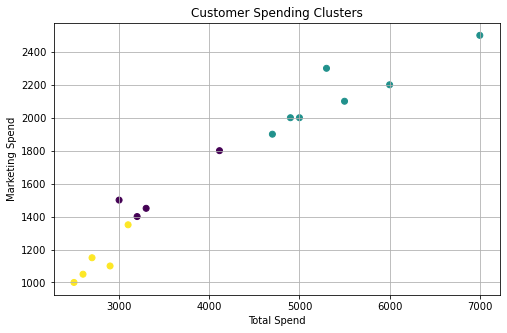

In [22]:
# Select relevant features
X = df[['Total_Spend', 'Marketing_Spend', 'Purchase_Frequency', 'Seasonality_Index']]

# Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply K-Means with 3 clusters (Low, Medium, High spenders)
kmeans = KMeans(n_clusters=3, random_state=42)
df['Spending_Cluster'] = kmeans.fit_predict(X_scaled)

# Show clustered data
print(df[['Customer_Name', 'Total_Spend', 'Spending_Cluster']])

# Optional: Plot clusters (2D view using just Total_Spend vs Marketing_Spend)
plt.figure(figsize=(8, 5))
plt.scatter(df['Total_Spend'], df['Marketing_Spend'], c=df['Spending_Cluster'], cmap='viridis')
plt.xlabel('Total Spend')
plt.ylabel('Marketing Spend')
plt.title('Customer Spending Clusters')
plt.grid(True)
plt.show()

In [23]:
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler

In [24]:
# Encode the target column 'Churned' (Yes/No -> 1/0)
le = LabelEncoder()
df['Churned_Encoded'] = le.fit_transform(df['Churned'])

# Select features and target
X = df[['Total_Spend', 'Marketing_Spend', 'Purchase_Frequency', 'Seasonality_Index']]
y = df['Churned_Encoded']

# Scale features (optional but helpful)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Train Random Forest
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)
rf_preds = rf_model.predict(X_test)

# Evaluate
print("Random Forest")
print("Accuracy:", accuracy_score(y_test, rf_preds))
print(classification_report(y_test, rf_preds))

# Train XGBoost
xgb_model = XGBClassifier(eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)
xgb_preds = xgb_model.predict(X_test)

# Evaluate
print("XGBoost")
print("Accuracy:", accuracy_score(y_test, xgb_preds))
print(classification_report(y_test, xgb_preds))


Random Forest
Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         2

    accuracy                           1.00         4
   macro avg       1.00      1.00      1.00         4
weighted avg       1.00      1.00      1.00         4

XGBoost
Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         2

    accuracy                           1.00         4
   macro avg       1.00      1.00      1.00         4
weighted avg       1.00      1.00      1.00         4

